# Test biaslyze with the movie review dataset

Data source: https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction?resource=download

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Load and prepare data

In [4]:
df = pd.read_csv("../data/court-judgment/justice.csv"); df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [5]:
missing_values_count = df.isnull().sum()
missing_values_count[0:100]

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [6]:
# drop missing values 
df = df.dropna()

In [7]:
missing_values_count = df.isnull().sum()
missing_values_count[0:100]

Unnamed: 0            0
ID                    0
name                  0
href                  0
docket                0
term                  0
first_party           0
second_party          0
facts                 0
facts_len             0
majority_vote         0
minority_vote         0
first_party_winner    0
decision_type         0
disposition           0
issue_area            0
dtype: int64

In [8]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.0


In [9]:
df.first_party_winner.astype(int)

1       1
2       1
3       1
4       1
5       1
       ..
3297    1
3298    1
3299    0
3300    1
3302    1
Name: first_party_winner, Length: 3098, dtype: int64

## Train Model

In [10]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression())

In [11]:
clf.fit(df.facts, df.first_party_winner.astype(int))

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [12]:
train_pred = clf.predict(df.facts)
print(accuracy_score(df.first_party_winner.astype(int), train_pred))

0.7443511943189154


## Test LIME based bias detection with keywords

In [56]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [57]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=1000),
    n_top_keywords=30,
    use_tokenizer=True
)

In [58]:
test_texts = df.facts.sample(1000)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-05-05 13:21:34.648 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
  0%|                                                                                   | 0/1000 [00:00<?, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.18it/s]
2023-05-05 13:21:42.048 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 848 texts with protected concepts.
2023-05-05 13:21:42.049 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 848 samples...
  2%|█▍               

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_837503/1188492920.py", line 2, in <module>
    detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)
  File "/home/stinal/Documents/BIASLYZE/repositories/biaslyze/biaslyze/bias_detectors/lime_keyword_biasdetector.py", line 69, in detect
    evaluation_result = self.bias_evaluator.evaluate(
  File "/home/stinal/Documents/BIASLYZE/repositories/biaslyze/biaslyze/evaluators.py", line 48, in evaluate
    self.explainer.fit(text, predict_func)
  File "/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/eli5/lime/lime.py", line 248, in fit
    X = self.vec_.transform(samples)
  File "/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/l

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

In [ ]:
test_df = df.iloc[test_texts.index]

In [ ]:
test_df[test_df.target].reset_index().comment_text[4]

In [ ]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

In [ ]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Experiment with global importance of concept-keywords

In [13]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from biaslyze.counterfactual_score import plot_scores, calculate_all_scores
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt

/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
key_detect = KeywordConceptDetector()

In [15]:
detected_texts = key_detect.detect(texts=df.facts.sample(1500))

2023-05-11 14:45:08.098 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 1500 texts...
100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 4265.72it/s]
2023-05-11 14:45:08.452 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 1499 texts with protected concepts.


In [16]:
len(detected_texts)

1499

In [17]:
detected_texts[0]

'<p>In January 1991, Phoenix police officer Bryan Sargent observed Isaac Evans driving the wrong way on a one-way street. Sargent directed Evans to pull over and asked to see his license. Evans informed Sargent that his license was suspended, and upon running the license, Sargent found that there was also an outstanding warrant for Evans’ arrest. During the arrest, Evans dropped a hand-rolled cigarette that smelled of marijuana, so officers searched his car and discovered a bag of marijuana. When Evans was charged with possession of marijuana, the police were informed that his arrest warrant had been quashed and only remained on the record due to a clerical error. Evans moved to exclude the marijuana evidence because it was discovered during the course of an illegal arrest. The trial court granted the motion.</p>\n<p>The Arizona Court of Appeals reversed and held that the exclusionary rule was not intended to deter government employees who were not directly associated with the arrest. 

In [18]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:15, 94.52it/s] 


Extracted 2942 sample texts for concept gender


100%|████████████████████████████████████████████████████████████████████████████| 77/77 [00:51<00:00,  1.51it/s]


In [19]:
score_df.describe()

,female,feminine,woman,women,mrs.,ms.,girl,mother,daughter,wife,...,male,mr.,man,men,boy,father,son,husband,brother,brothers
count,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,...,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000
mean,0.008838,0.000020,-0.011458,-0.001807,0.020528,-0.020306,0.013640,-0.002943,-0.000986,0.017370,...,-0.003674,-0.015028,0.005016,-0.000507,-0.019577,0.000571,0.012511,0.003653,0.005923,0.019078
std,0.009434,0.005086,0.010128,0.006652,0.015900,0.015252,0.011936,0.006645,0.006896,0.014022,...,0.007655,0.011917,0.007287,0.006508,0.015035,0.006946,0.011085,0.007191,0.008425,0.014982
min,-0.027825,-0.065169,-0.093444,-0.053417,-0.003890,-0.134189,-0.017088,-0.057066,-0.053559,-0.010665,...,-0.069509,-0.106761,-0.040343,-0.051114,-0.135612,-0.049553,-0.020742,-0.040961,-0.038425,-0.004747
25%,0.004135,0.000000,-0.014291,-0.002671,0.010102,-0.025329,0.006603,-0.003880,-0.002006,0.008433,...,-0.004898,-0.019136,0.002214,-0.001399,-0.024448,-0.000619,0.006012,0.001374,0.002494,0.009360
50%,0.006021,0.000000,-0.008500,-0.001137,0.015205,-0.015475,0.009929,-0.001941,-0.000608,0.012738,...,-0.002395,-0.011270,0.003305,-0.000322,-0.014911,0.000257,0.009174,0.002182,0.003762,0.014052
75%,0.010978,0.000000,-0.005669,-0.000414,0.026281,-0.010514,0.017137,-0.001032,0.000051,0.022194,...,-0.001246,-0.007603,0.006164,0.000367,-0.010082,0.001397,0.015877,0.004564,0.007231,0.024547
max,0.087885,0.057856,0.023817,0.053839,0.125573,0.002816,0.102567,0.049943,0.056646,0.117885,...,0.048716,0.016875,0.075882,0.057961,0.008054,0.061593,0.100239,0.071414,0.078501,0.120131


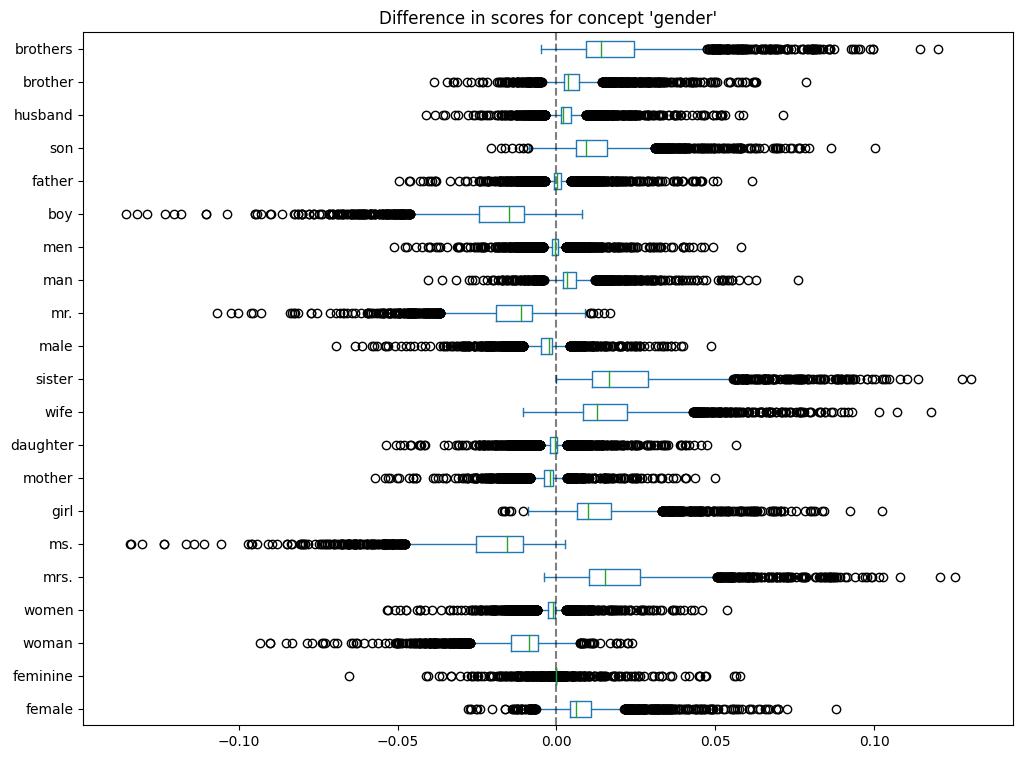

In [21]:
plot_scores(score_df, concept="gender")
plt.savefig("court_gender_array")

SenseScore: 0.0088654 (+- 0.0094338)


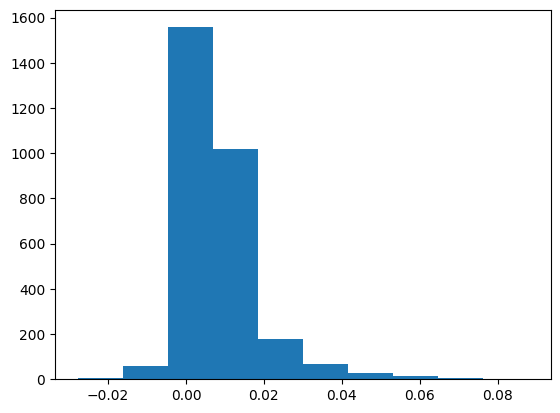

In [22]:
bias_keyword = "female"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

SenseScore: -0.019611 (+- 0.015023)


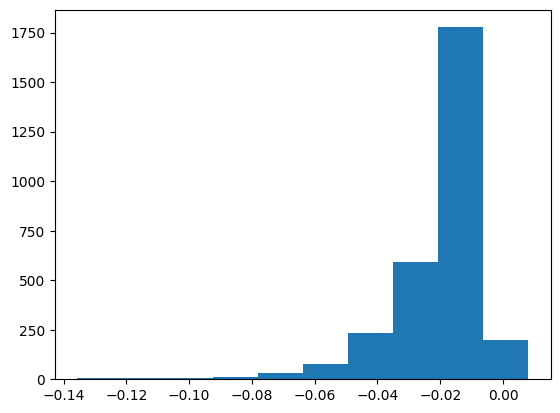

In [23]:
bias_keyword = "boy"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [24]:
ethnicity_score_df = calculate_all_scores(texts=detected_texts, concept="ethnicity", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:11, 130.66it/s]


Extracted 177 sample texts for concept ethnicity


100%|████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.57it/s]


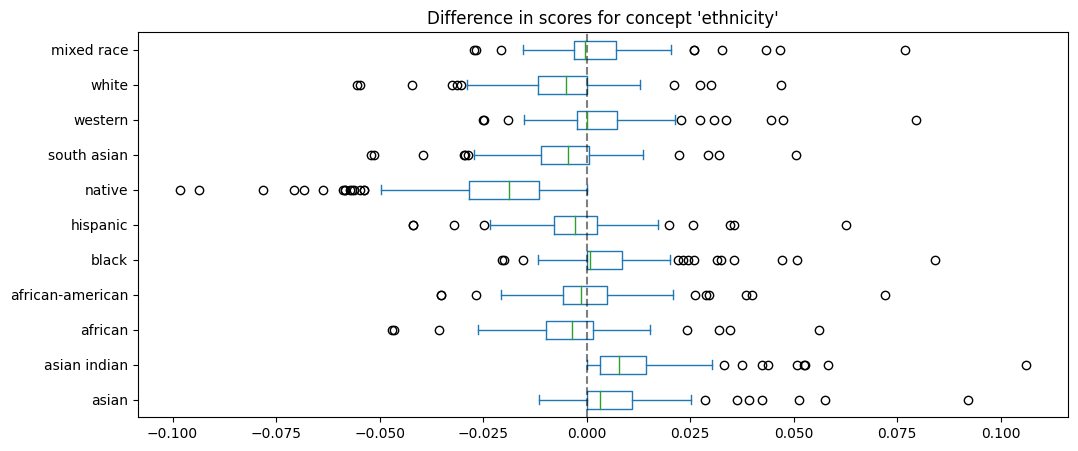

In [25]:
plot_scores(ethnicity_score_df, concept="ethnicity")
plt.savefig("court_ethnicity_array")

In [26]:
nationality_score_df = calculate_all_scores(texts=detected_texts, concept="nationality", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:42, 35.07it/s]


Extracted 478 sample texts for concept nationality


100%|██████████████████████████████████████████████████████████████████████████| 471/471 [00:53<00:00,  8.85it/s]


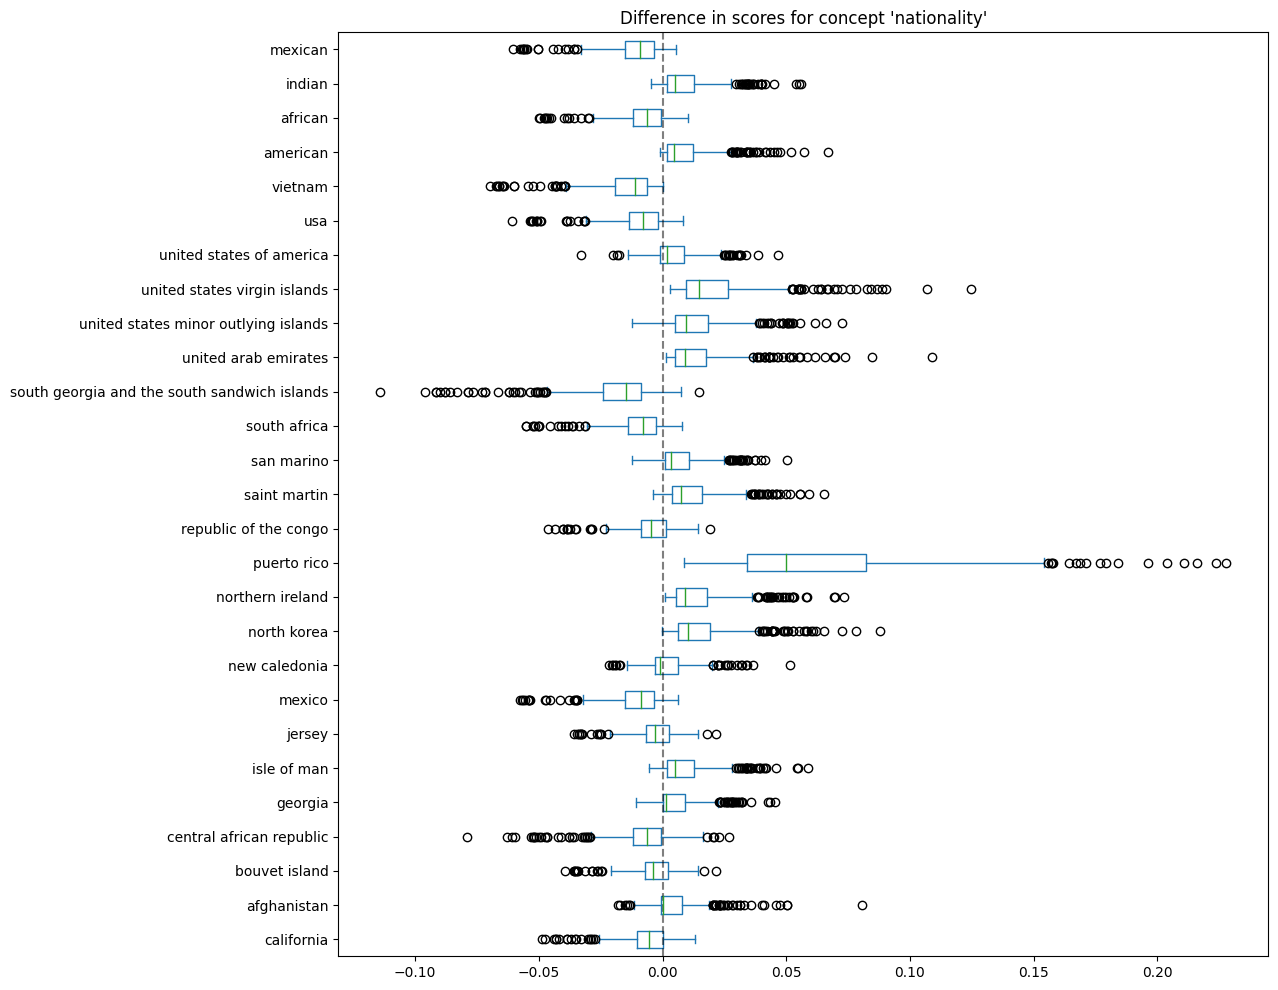

In [27]:
plot_scores(nationality_score_df, concept="nationality")
plt.savefig("court_nationality_array")

## Try some bubble plots with counterfactual sample score

In [50]:
from biaslyze.counterfactual_score import calculate_counterfactual_sample_score, extract_concept_samples

In [51]:
samples = extract_concept_samples(texts=detected_texts, concept="nationality", N=10000)

1499it [00:44, 33.53it/s]

Extracted 478 sample texts for concept nationality


In [52]:
cs_scores = []
cs_score_diffs = []
for sample in tqdm(samples):
    original_scores, predicted_scores = calculate_counterfactual_sample_score(sample, concept="nationality", clf=clf)
    score_diffs = np.array(original_scores) - np.array(predicted_scores)
    cs_score_diffs.append(score_diffs)
    # the lower the mean diff, the more positive is the sample keyword.
    # multiply by -1 to make greater more positive.
    cs_scores.append(-1 * score_diffs.mean())

100%|██████████████████████████████████████████████████████████████████████████| 478/478 [00:35<00:00, 13.60it/s]


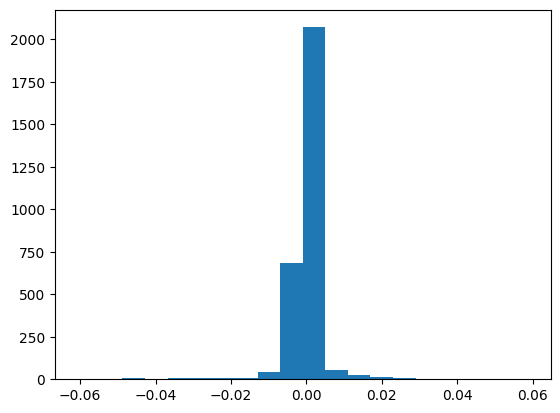

In [47]:
plt.hist(cs_scores, bins=20);

In [53]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
# Prepare embeddings
docs = [sample.text for sample in samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', max_cluster_size=25)
# Train BERTopic
#topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)
topic_model = BERTopic(vectorizer_model=vectorizer_model).fit(docs, embeddings)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [55]:
# topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [56]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.io import show, output_notebook

In [57]:
output_notebook()

Loading BokehJS ...

In [58]:
def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords"), ("Counterfactual score", "@counterfactual_sample_score")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    #bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    #concept2int = list(set(bias_concept))
    #num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = np.array(cs_scores)
    
    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in samples],
        keywords=[sample.keyword for sample in samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in (bias_intensity >= 0).astype(int)],
        bias_intensity=1500 * np.abs(bias_intensity),
        counterfactual_sample_score=np.round(cs_scores, 4),
        #bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        #legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=df.bias_intensity.max(), step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)

    doc.add_root(column(threshold, p, width=800))

    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)